In [52]:
# Import necessary modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [53]:
# Load the images directories
path = "data/brain_tumor_dataset"
print(os.listdir(path))
image_paths = list(paths.list_images(path))
print(len(image_paths))

['no', 'yes']
253


In [54]:
#adding all imags and labels into list
images = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(label)

label : no


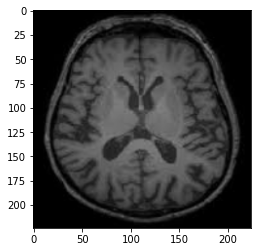

In [55]:
#plotting image using matplotlib
def plotting_image(image,label):
    plt.imshow(image)
    print(f"label : {label}")

plotting_image(images[1],labels[1])

In [56]:
#converting into numpy arrays and normalizing imges
images = np.array(images)/225.0
labels = np.array(labels)

In [57]:
#encoding labels, One-hot encoding
print(f'before encoding : {labels[0]}')
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)
print(f'after encoding : {labels[0]}')

before encoding : no
after encoding : [1. 0.]


In [64]:
#dataset splitting
X_train, X_test, y_train, y_test = train_test_split(images,labels,test_size=0.10,random_state=42,stratify=labels)

In [65]:
# Build the Image Data Generator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

model building

In [66]:
# Build the model
base_model = VGG16(weights= 'imagenet',input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58889256/58889256 [==============================] - 36s 1us/step


In [67]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False 

In [68]:
# Compile the model
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [69]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

training model

In [70]:
batch_size = 8
train_steps = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size
epochs = 10

In [71]:
# Fit the model
model_history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size = batch_size),
                                    steps_per_epoch = train_steps,
                                    validation_data = (X_test, y_test),
                                    validation_steps = validation_steps,
                                    epochs = epochs)

C:\Users\Saranga\AppData\Local\Temp\ipykernel_19888\2586315490.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size = batch_size),


Epoch 1/10
28/28 [==============================] - 51s 2s/step - loss: 0.7738 - accuracy: 0.5708 - val_loss: 0.6103 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 48s 2s/step - loss: 0.6538 - accuracy: 0.6484 - val_loss: 0.5670 - val_accuracy: 0.6923
Epoch 3/10
28/28 [==============================] - 53s 2s/step - loss: 0.6174 - accuracy: 0.6804 - val_loss: 0.5335 - val_accuracy: 0.8462
Epoch 4/10
28/28 [==============================] - 53s 2s/step - loss: 0.5977 - accuracy: 0.6941 - val_loss: 0.4798 - val_accuracy: 0.8077
Epoch 5/10
28/28 [==============================] - 54s 2s/step - loss: 0.5940 - accuracy: 0.6804 - val_loss: 0.4622 - val_accuracy: 0.9231
Epoch 6/10
28/28 [==============================] - 53s 2s/step - loss: 0.5403 - accuracy: 0.7717 - val_loss: 0.4277 - val_accuracy: 0.9231
Epoch 7/10
28/28 [==============================] - 51s 2s/step - loss: 0.5378 - accuracy: 0.7763 - val_loss: 0.3904 - val_accuracy: 0.9615
Epoch 8/10
28/28 [==

evalution

In [72]:
# Evaluate the model
pred = model.predict(X_test, batch_size = batch_size)
pred = np.argmax(pred, axis = 1)
actuals = np.argmax(y_test, axis = 1)

4/4 [==============================] - 4s 991ms/step


In [73]:
# Print Classification report and Confusion matrix
print(classification_report(actuals, pred, target_names = label_binarizer.classes_))
cm = confusion_matrix(actuals, pred)
print(cm)

              precision    recall  f1-score   support

          no       0.90      0.90      0.90        10
         yes       0.94      0.94      0.94        16

    accuracy                           0.92        26
   macro avg       0.92      0.92      0.92        26
weighted avg       0.92      0.92      0.92        26

[[ 9  1]
 [ 1 15]]


In [74]:
# Final accuracy of our model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9231


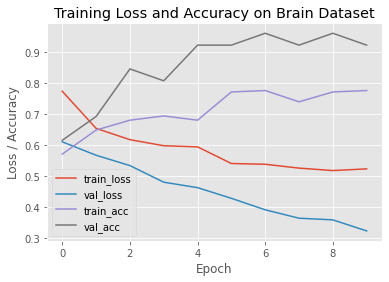

In [75]:
# Plot the losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), model_history.history["val_loss"], label= "val_loss")
plt.plot(np.arange(0, N), model_history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), model_history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")